In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ultranest
import read_beam_FEKO as rf
import scipy.interpolate
import scipy.optimize
%matplotlib notebook

In [2]:
o = rf.read_beam_FEKO('nominal.out',0)

 Frequency in Hz:               FREQ =    2.50000E+07

 Frequency in Hz:               FREQ =    2.60000E+07

 Frequency in Hz:               FREQ =    2.70000E+07

 Frequency in Hz:               FREQ =    2.80000E+07

 Frequency in Hz:               FREQ =    2.90000E+07

 Frequency in Hz:               FREQ =    3.00000E+07

 Frequency in Hz:               FREQ =    3.10000E+07

 Frequency in Hz:               FREQ =    3.20000E+07

 Frequency in Hz:               FREQ =    3.30000E+07

 Frequency in Hz:               FREQ =    3.40000E+07

 Frequency in Hz:               FREQ =    3.50000E+07

 Frequency in Hz:               FREQ =    3.60000E+07

 Frequency in Hz:               FREQ =    3.70000E+07

 Frequency in Hz:               FREQ =    3.80000E+07

 Frequency in Hz:               FREQ =    3.90000E+07

 Frequency in Hz:               FREQ =    4.00000E+07

 Frequency in Hz:               FREQ =    4.10000E+07

 Frequency in Hz:               FREQ =    4.20000E+07

 Frequency

In [3]:
# Define theta as an array from [90 to 0]. phi is from [0 to 359], freq from [25 to 125 MHz]
theta = 90 - o[2]
phi = o[1]
freq = o[0]
gain = o[5]
xx, yy = np.meshgrid(theta, phi)
#xx is for theta, and yy is for phi

In [9]:
theta = xx
phi = yy

In [10]:
#The fundamental TDH functions
#Acos,Asin taken theta in degree
def Acos(R, theta, miu, nu):
    part1 = np.cos(miu*theta*np.pi/180)*(R/(sigma/1.43))**miu
    part2 = P(miu,nu,R**2/(sigma/1.43)**2)
    part3 = np.exp(-R**2/(4*(sigma/1.43)**2))
    return part1*part2*part3

def Asin(R, theta, miu, nu):
    part1 = np.sin(miu*theta*np.pi/180)*(R/(sigma/1.43))**miu
    part2 = P(miu,nu,R**2/(sigma/1.43)**2)
    part3 = np.exp(-R**2/(4*(sigma/1.43)**2))
    return part1*part2*part3

def P(miu,nu,u):
    terms = []
    p = 0
    while p <= nu:
        up = np.math.factorial(miu + nu)*np.math.factorial(nu)
        down = np.math.factorial(miu + p)*np.math.factorial(p)*np.math.factorial(nu-p)
        term = (-2)**(nu-p)* up/down * u**p
        terms.append(term)
        p += 1
    terms = np.array(terms)
    return np.sum(terms,axis = 0)

In [11]:
#make sigma a input parameter
def Acossig(R, theta, miu, nu, sigma):
    part1 = np.cos(miu*theta*np.pi/180)*(R/(sigma/1.43))**miu
    part2 = P(miu,nu,R**2/(sigma/1.43)**2)
    part3 = np.exp(-R**2/(4*(sigma/1.43)**2))
    return part1*part2*part3

def Asinsig(R, theta, miu, nu, sigma):
    part1 = np.sin(miu*theta*np.pi/180)*(R/(sigma/1.43))**miu
    part2 = P(miu,nu,R**2/(sigma/1.43)**2)
    part3 = np.exp(-R**2/(4*(sigma/1.43)**2))
    return part1*part2*part3

In [124]:
#Normalization
def normalize(array):
    q = 0
    theta = 0
    while theta <= 90:
        for i in range(360):
            q += (array[theta*360 + i])**2 * (np.pi/180)**2 * np.sin(theta*np.pi/180)
        theta += 1
    return array/q

def TDH(rank):
    """return matrix A = [f1, f2, f3, ...] for rank 0 to rank TDH functions"""
    zz00c = Acos(newtheta, newphi, 0, 0)
    zz00c2d = zz00c.flatten()
    array = normalize(zz00c2d)
    r = 1
    while r <= rank:
        m = 0
        while m <= r:
            if (r - m)%2 == 0:
                n = (r - m)/2
                if m == 0:
                    cosine = Acos(newtheta,newphi,m,n)
                    cosine2d = cosine.flatten()
                    ncos = normalize(cosine2d)
                    array = np.vstack((array, ncos))
                    m += 2
                else:
                    cosine = Acos(newtheta,newphi,m,n)
                    cosine2d = cosine.flatten()
                    ncos = normalize(cosine2d)
                    sine = Asin(newtheta,newphi,m,n)
                    sine2d = sine.flatten()
                    nsin = normalize(sine2d)
                    array = np.vstack((array, ncos))
                    array = np.vstack((array, nsin))
                    m += 2
            else:
                m += 1
        r += 1
    matrix = np.matrix(array).T
    return matrix

def model(rank, coe):
    A = TDH(rank)
    a = np.matrix(coe).T
    return np.matmul(A,a)

def simulation(coe, sigma):
    rank = 0
    count = 1
    length = len(coe) - 1
    while length > count:
        rank += 1
        count += rank + 1
    mo = model(rank,coe)
    noise = np.random.default_rng().normal(0.0, sigma*np.max(mo),360*91)
    noi = np.matrix(noise).T
    data = mo + noi
    return data

def solve(A, data):
    AT = A.T
    ATA = np.matmul(AT,A)
    ATAinverse = np.linalg.inv(ATA)
    half = np.matmul(ATAinverse,AT)
    x = np.matmul(half,data)
    return x

def residual(A,data):
    x = solve(A, data)
    AT = A.T
    fittingmodel = np.matmul(A, x)
    r = data - fittingmodel
    return r

def residual2D(A,data):
    r = residual(A,data)
    r2D = r.reshape(360,91)
    return r2D

def covariance(A,data):
    AT = A.T
    ATA = np.matmul(AT,A)
    ATAinverse = np.linalg.inv(ATA)
    r = residual(A,data)
    rT = r.T
    rTr = np.matmul(rT,r)
    s = rTr/((len(data))-len(AT)) 
    '''Originally: s = rTr/((len(data))-10). I think the 10 is weird.'''
    s2 = s.item(0)
    covariance = s2*ATAinverse
    return covariance

In [161]:
# 2D Gaussian data fitting using UltraNest
#Which one
def Gaussian2D(A, sigx, sigy):
    return A * np.exp(-(np.sin(theta*np.pi/180)*np.cos(phi*np.pi/180))**2/2/sigx**2 - (np.sin(theta*np.pi/180)*np.sin(phi*np.pi/180))**2/2/sigy**2)

def Gaussian2D(A, sigx, sigy):
    return A * np.exp(-(theta*np.pi/180*np.cos(phi*np.pi/180))**2/2/sigx**2 - (theta*np.pi/180*np.sin(phi*np.pi/180))**2/2/sigy**2)

# Define model to simulate data
def model1(paras):
    A, sigx, sigy = paras
    return Gaussian2D(A,sigx,sigy).T

sigma = np.std(gain[0])
param_names = ['A', 'sigx', 'sigy']
def my_prior_transform(cube):
    params = cube.copy()

    # transform location parameter: uniform prior
    lo = 0
    hi = 10
    params[0] = cube[0] * (hi - lo) + lo

    lo = 0
    hi = 2
    params[1] = cube[1] * (hi - lo) + lo

    lo = 0
    hi = 2
    params[1] = cube[1] * (hi - lo) + lo
    
    return params
def my_likelihood(params):
    mo = model1(params)
    diff = mo - gain[0]
    return -0.5 * np.sum((diff/sigma)**2)

In [162]:
sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, my_prior_transform)
result = sampler.run(min_num_live_points=200)
sampler.print_results()

[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-1e+03  147.78 [-1147.8322..-1147.8322]*| it/evals=4660/9415 eff=50.5697% N=200       0 0  
[ultranest] Likelihood function evaluations: 9416
[ultranest]   logZ = -1167 +- 0.2494
[ultranest] Effective samples strategy satisfied (ESS = 938.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 198 minimum live points (dlogz from 0.22 to 0.56, need <0.5)
[ultranest]   logZ error budget: single: 0.29 bs:0.25 tail:0.01 total:0.25 required:<0.50
[ultranest] done iterating.

logZ = -1166.511 +- 0.412
  single instance: logZ = -1166.511 +- 0.294
  bootstrapped   : logZ = -1166.522 +- 0.412
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    A                   : 0.5525│ ▁ ▁  ▁▁▁▁▁▁▂▂▄▄▅▆▆▇▆▇▇▇▆▄▅▃▂▂▁▁▁▁▁▁▁▁ │0.5708    0.5623 +- 0.0021
    sigx                : 0.5186│ ▁ ▁▁▁▁▁▁▂▁▂▃▃▅▆▇▆▆▇▇▇▆▆▅▄▄▃▂▂▁▁▁▁▁▁▁▁ │0.5408

In [15]:
thetaf = theta.flatten()
phif = phi.flatten()

<IPython.core.display.Javascript object>


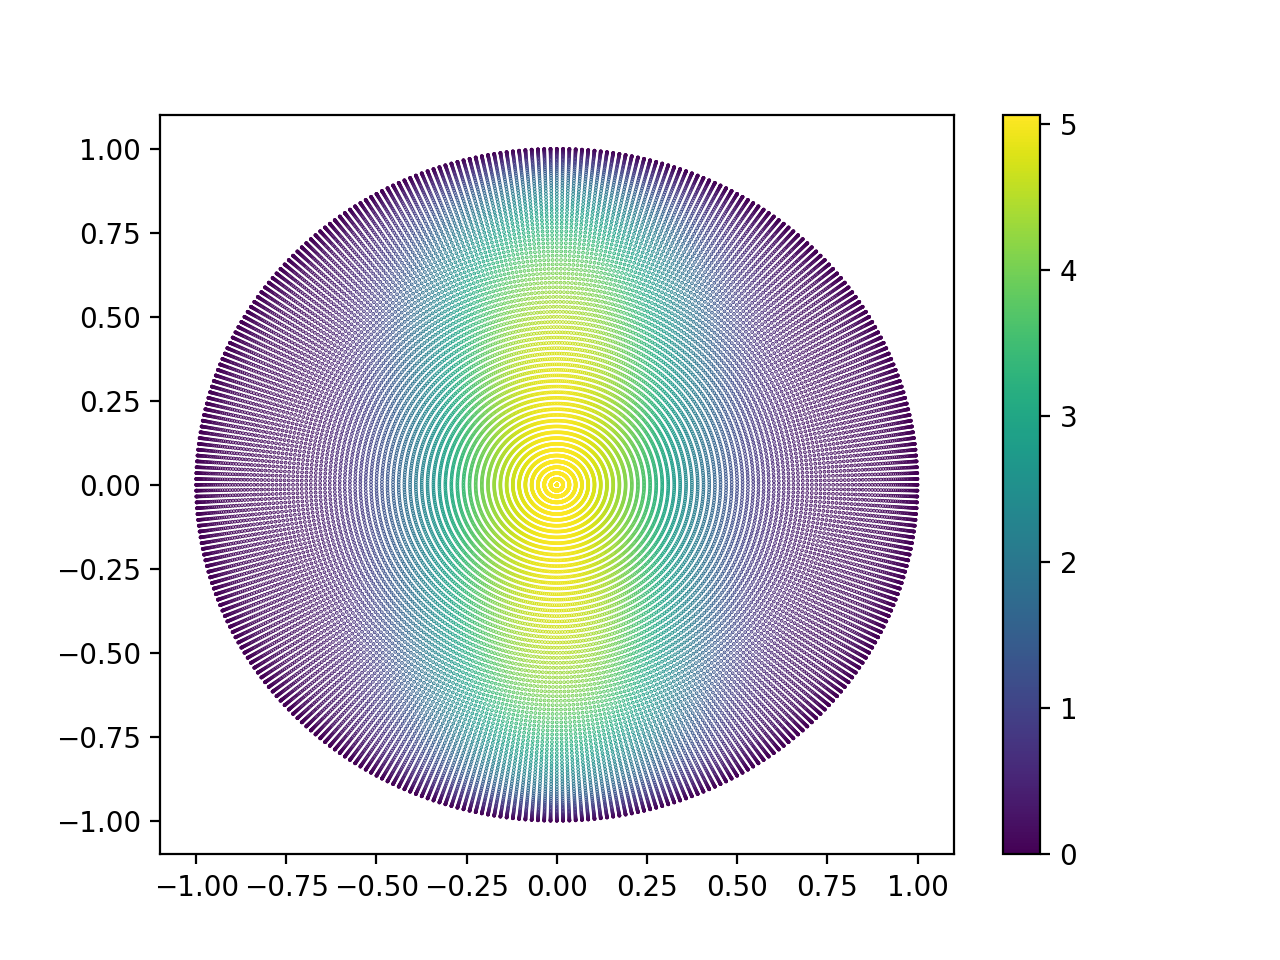

In [81]:
plt.figure(1)
x = np.cos(phif*np.pi/180)*np.sin(thetaf*np.pi/180)
y = np.sin(phif*np.pi/180)*np.sin(thetaf*np.pi/180)
plt.scatter(x,y,c = gain[100].T, s = 0.1)
plt.colorbar()

In [31]:
ratio = np.average(result['samples'].T[2])/np.average(result['samples'].T[1])

In [32]:
newx = x
newy = y/ratio
newphi = np.arctan2(newy,x)
newtheta = np.arcsin(np.sqrt(newx**2+newy**2))

<IPython.core.display.Javascript object>


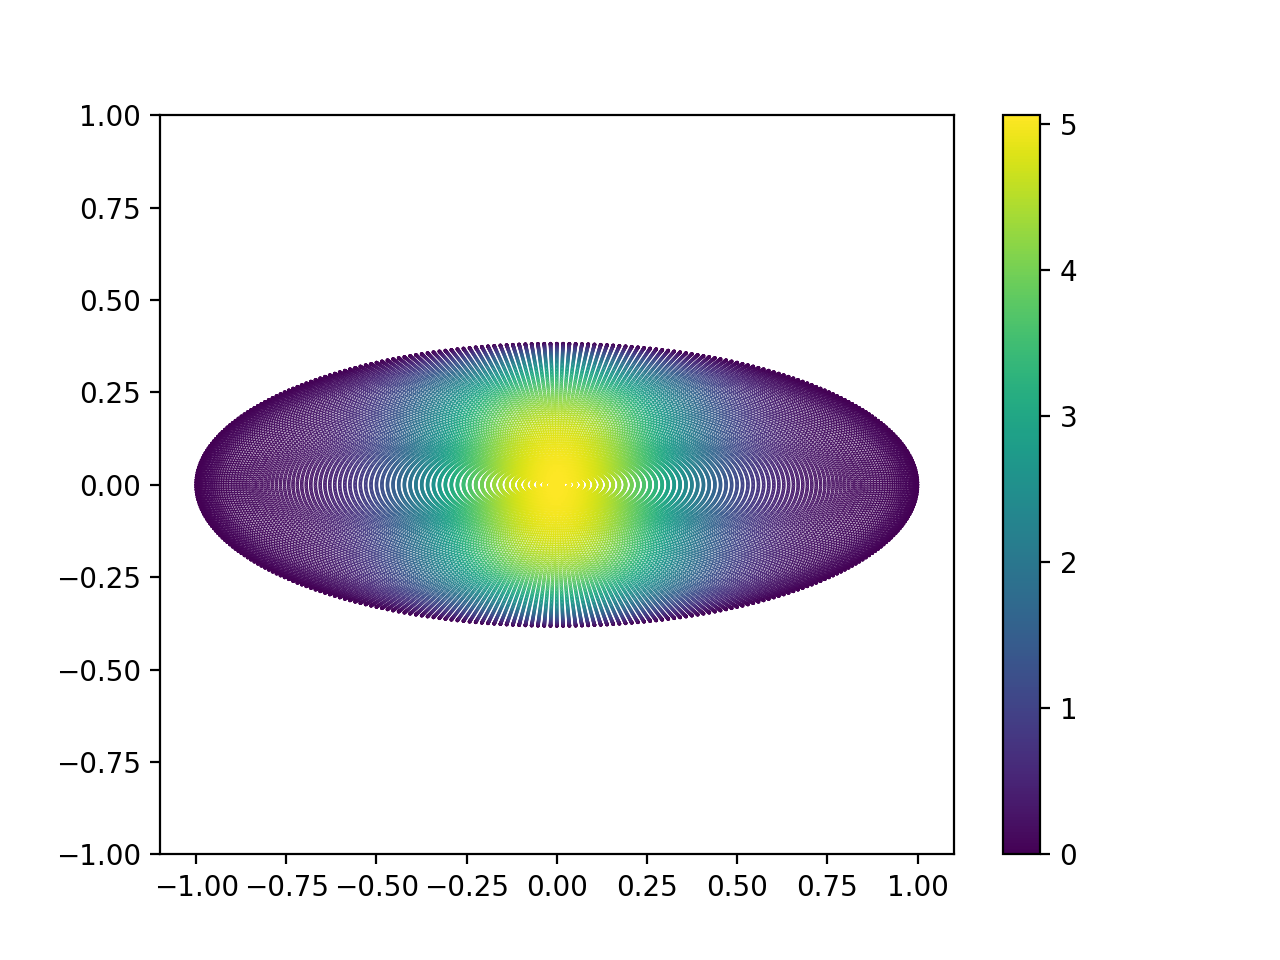

In [82]:
plt.figure(2)
plt.ylim(-1,1)
plt.scatter(newx,newy,c = gain[100].T, s = 0.1)
plt.colorbar()

<IPython.core.display.Javascript object>


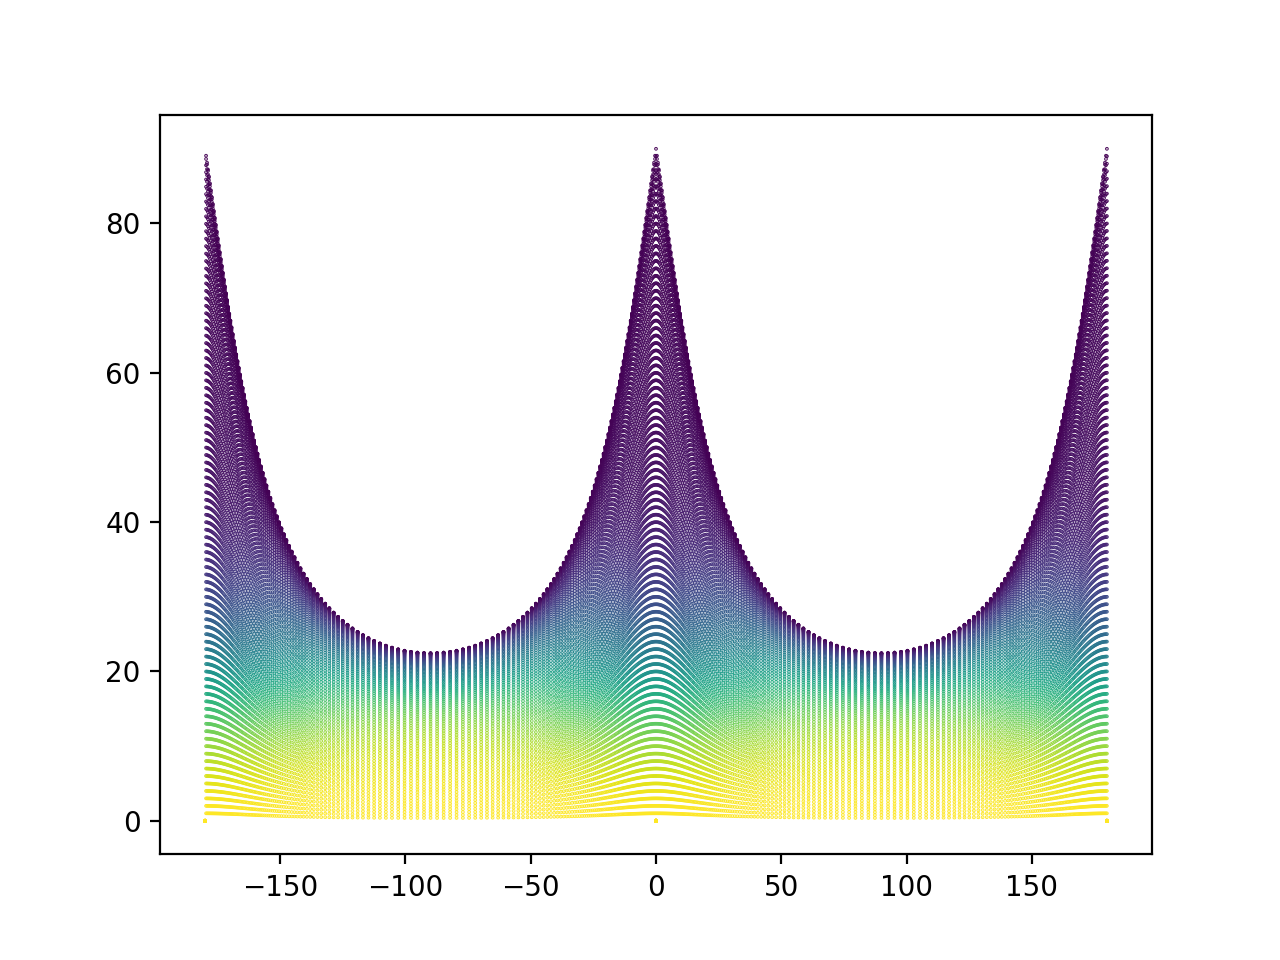

In [83]:
plt.figure(3)
plt.scatter(newphi*180/np.pi,newtheta*180/np.pi,c = gain[100].T,s=0.1)

In [99]:
A.T[0].reshape(360,91).shape

(360, 91)

In [126]:
sigma = 0.3147*180/np.pi
A = TDH(6)
data = np.matrix(gain[100].T.flatten())
coe = solve(A,data.T)
finalresi = residual2D(A,data.T)
fittingmodel = np.matmul(A, coe)
fittingmodel2D = fittingmodel.reshape(360,91)

In [127]:
meansquare = np.sum(np.multiply(finalresi,finalresi))/(360*91)
rms = np.sqrt(meansquare)
rms/np.max(gain[100])*100

134.6104828790945

In [91]:
newx.shape

(32760,)

In [142]:
newx.reshape(360,91)

array([[1.        , 0.9998477 , 0.99939083, ..., 0.0348995 , 0.01745241,
        0.        ],
       [0.9998477 , 0.99969541, 0.99923861, ..., 0.03489418, 0.01744975,
        0.        ],
       [0.99939083, 0.99923861, 0.99878203, ..., 0.03487824, 0.01744177,
        0.        ],
       ...,
       [0.99862953, 0.99847744, 0.9980212 , ..., 0.03485167, 0.01742849,
        0.        ],
       [0.99939083, 0.99923861, 0.99878203, ..., 0.03487824, 0.01744177,
        0.        ],
       [0.9998477 , 0.99969541, 0.99923861, ..., 0.03489418, 0.01744975,
        0.        ]])

In [152]:
newy.reshape(360,91)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00666296,  0.00666195,  0.0066589 , ...,  0.00023253,
         0.00011628,  0.        ],
       [ 0.01332389,  0.01332186,  0.01331578, ...,  0.000465  ,
         0.00023253,  0.        ],
       ...,
       [-0.01998076, -0.01997772, -0.01996859, ..., -0.00069732,
        -0.00034871, -0.        ],
       [-0.01332389, -0.01332186, -0.01331578, ..., -0.000465  ,
        -0.00023253, -0.        ],
       [-0.00666296, -0.00666195, -0.0066589 , ..., -0.00023253,
        -0.00011628, -0.        ]])

<IPython.core.display.Javascript object>


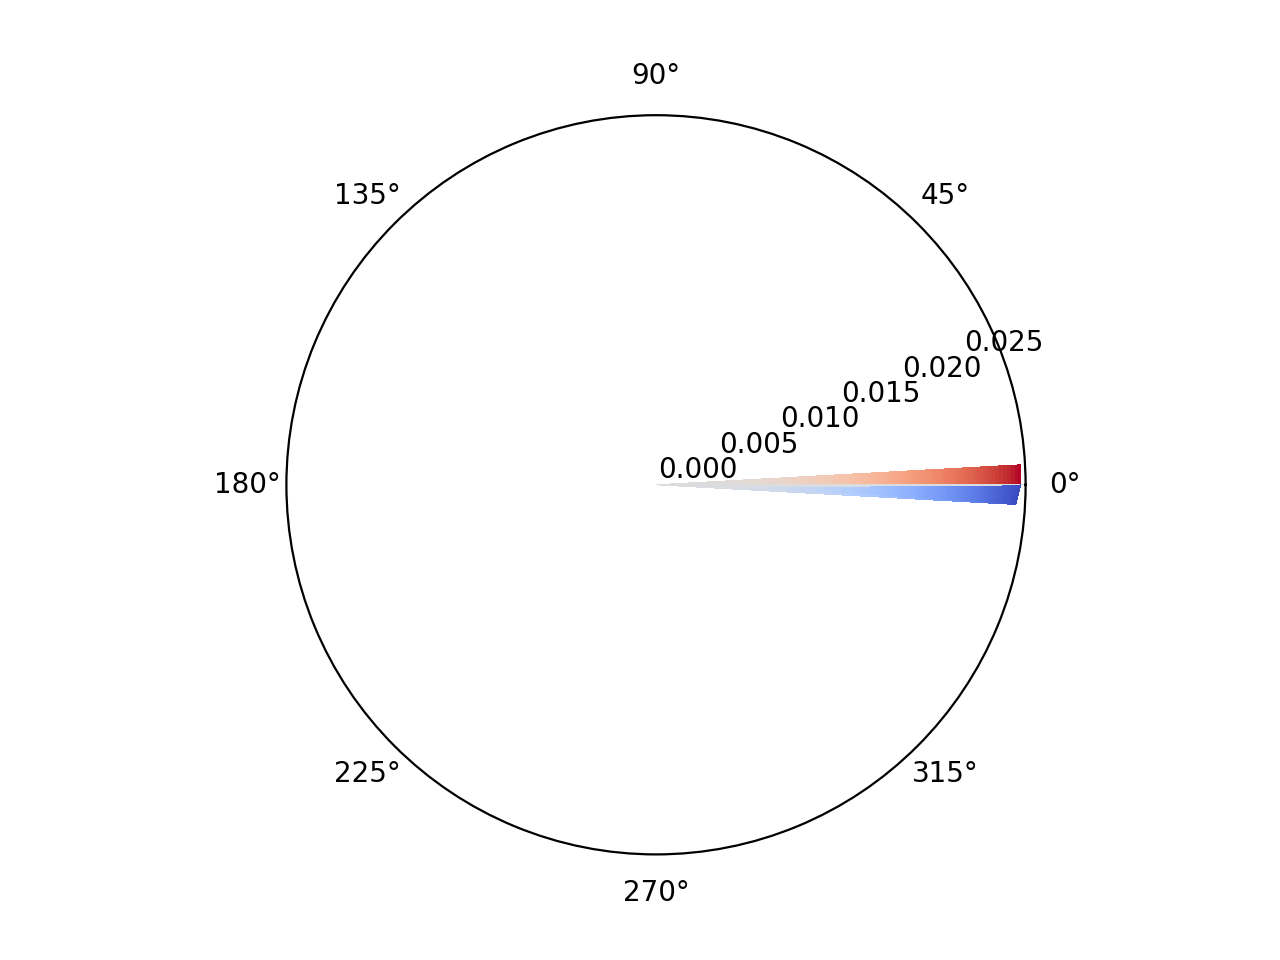

<ipython-input-134-603e7403a891>:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs.pcolormesh(newphi2D*np.pi/180,newtheta2D*np.pi/180,A.T[5].reshape(360,91),cmap='coolwarm', shading = 'nearest')


In [134]:
fig, axs = plt.subplots(1, 1, subplot_kw=dict(projection="polar"))
axs.pcolormesh(newphi2D*np.pi/180,newtheta2D*np.pi/180,A.T[5].reshape(360,91),cmap='coolwarm', shading = 'nearest')

In [158]:
np.max(gain[100])

5.062208165243696

In [156]:
np.max(A.T[0])

0.15797147338001027

<IPython.core.display.Javascript object>


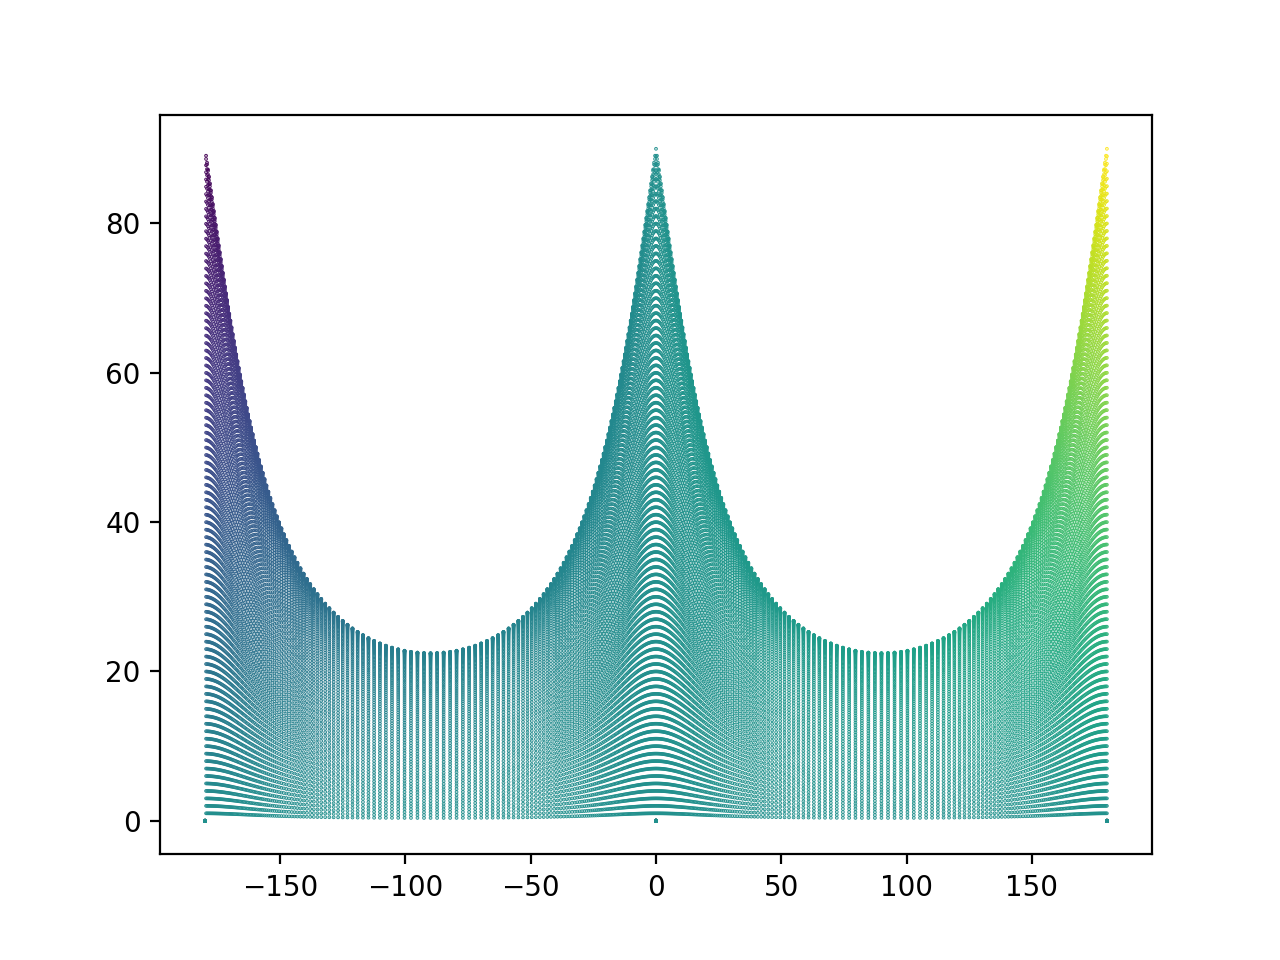

In [185]:
plt.figure(5)
plt.scatter(newphi*180/np.pi,newtheta*180/np.pi,c = np.array(A.T[2]).flatten(), s = 0.1)

In [133]:
newphi2D = newphi.reshape(360,91)
newtheta2D = newtheta.reshape(360,91)
newx2d = newx.reshape(91,360)
newy2d = newy.reshape(91,360)

<IPython.core.display.Javascript object>


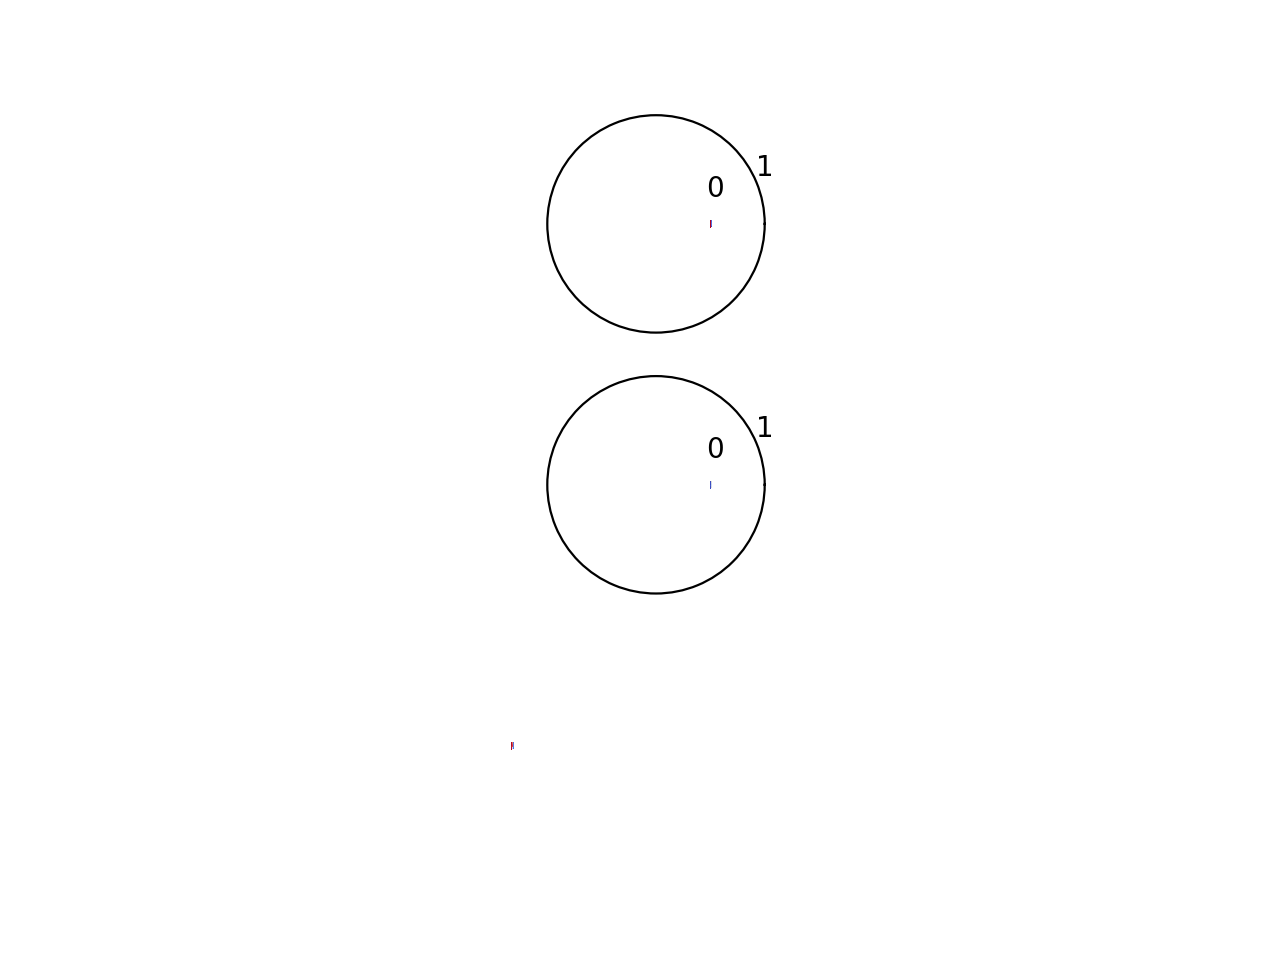

<ipython-input-78-66ebc36b64b3>:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs[0].pcolormesh(newphi2D*np.pi/180,newtheta2D*np.pi/180,gain[100].T,cmap='coolwarm',shading='nearest')
<ipython-input-78-66ebc36b64b3>:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs[1].pcolormesh(newphi2D*np.pi/180,newtheta2D*np.pi/180,fittingmodel2D,cmap='coolwarm',shading='nearest')
<ipython-input-78-66ebc36b64b3>:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell

In [78]:
fig, axs = plt.subplots(3, 1, subplot_kw=dict(projection="polar"),sharex = True, sharey = True)
axs[0].pcolormesh(newphi2D*np.pi/180,newtheta2D*np.pi/180,gain[100].T,cmap='coolwarm',shading='nearest')
axs[1].pcolormesh(newphi2D*np.pi/180,newtheta2D*np.pi/180,fittingmodel2D,cmap='coolwarm',shading='nearest')
axs[2].pcolormesh(newphi2D*np.pi/180,newtheta2D*np.pi/180,finalresi,cmap='coolwarm',shading='nearest')

<IPython.core.display.Javascript object>


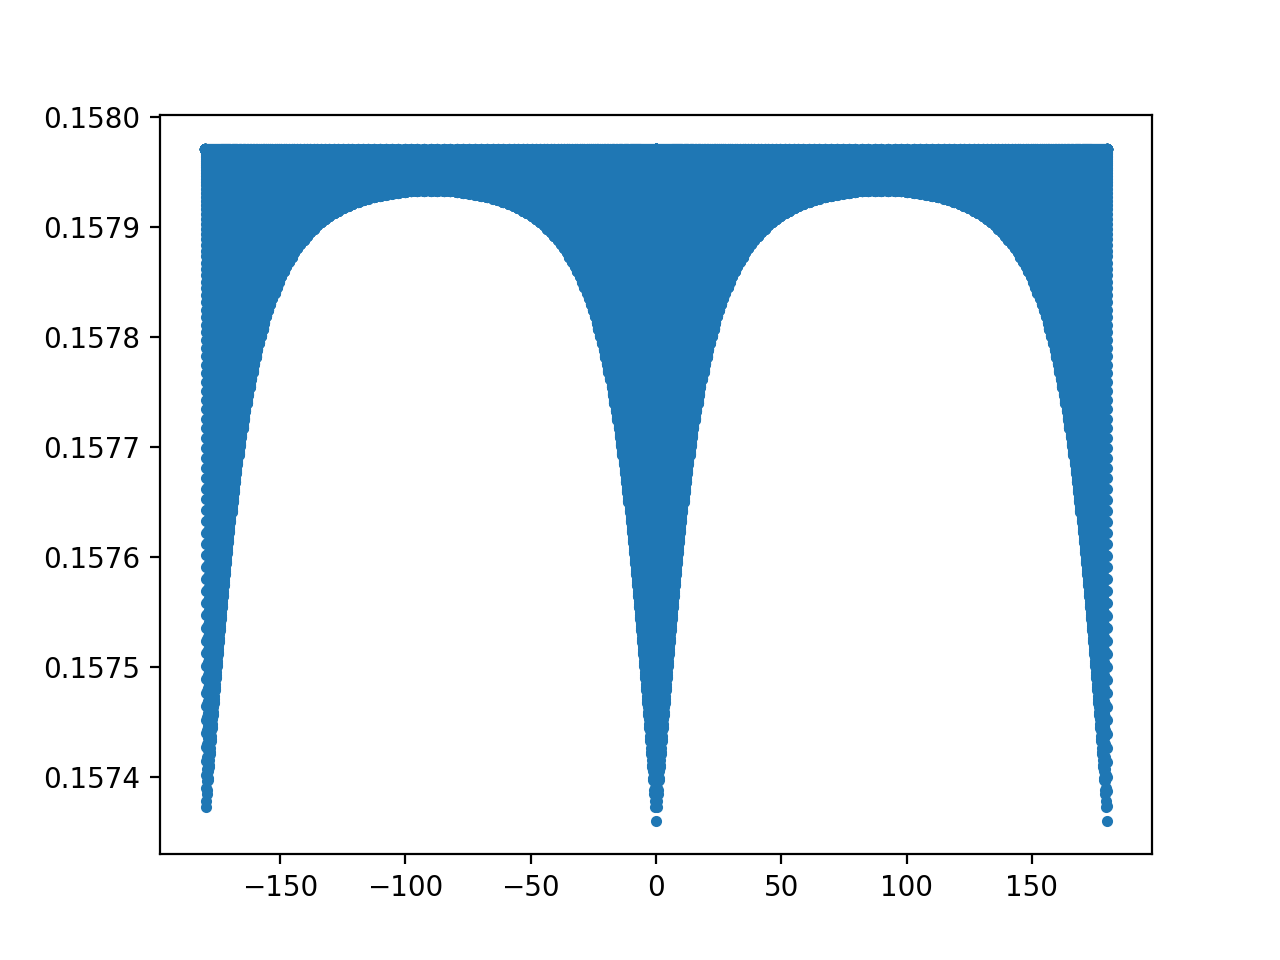

In [173]:
plt.figure()
plt.plot(newphi*180/np.pi, np.array(A.T[0]).flatten(), '.')